# Análisis Predictivo de Mantenimiento de Piscinas - Device 01

## Introducción

Este notebook presentamos la segunda parte en el que se usaran tecnicas de Machine learning para crear un análisis predictivo para el mantenimiento de piscinas utilizando datos recopilados de sistemas de monitoreo automático. El objetivo es desarrollar un modelo que pueda predecir la necesidad de activación del clorificador y anticipar cambios en el pH del agua. Se usan los datos ya tratados en el previo notebook.

## Objetivos

1. Desarrollar un modelo de clasificación para predecir la necesidad de activación del clorificador.
2. Implementar un modelo de series temporales para predecir cambios futuros en el pH.
3. Integrar ambos modelos en un sistema de predicción en cascada.

## Estructura del Análisis

1. Carga y preprocesamiento de datos
2. Análisis exploratorio de datos
3. Desarrollo del modelo de clasificación para la activación del clorificador4. Conclusiones y guardar el modelo

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tqdm import tqdm
import os

%matplotlib inline

En este análisis, hemos decidido comenzar entrenando nuestro modelo utilizando datos de un solo dispositivo (Device 01) en lugar de todos los dispositivos disponibles. Esta decisión se basa en varias consideraciones importantes:

1. **Variabilidad entre piscinas**: Cada piscina tiene condiciones únicas basadas en su localización, tamaño, uso y entorno. Esto se refleja en la variabilidad de los rangos de pH, ORP y otros parámetros entre los diferentes dispositivos, como se muestra en la tabla de resumen.

2. **Optimización específica**: Al entrenar un modelo para cada piscina individualmente, podemos optimizar el rendimiento para las condiciones específicas de esa piscina, lo que potencialmente conduce a predicciones más precisas y relevantes.

3. **Control de variables**: Comenzar con un solo dispositivo nos permite tener un mejor control sobre las variables y entender mejor cómo el modelo responde a un conjunto específico de condiciones antes de introducir la complejidad adicional de múltiples piscinas.

4. **Escalabilidad del enfoque**: Una vez que hayamos desarrollado y validado nuestro enfoque con un dispositivo, podremos escalar el proceso a los demás dispositivos, ya sea entrenando modelos individuales para cada uno o explorando técnicas de transferencia de aprendizaje.

5. **Comparación de rendimiento**: Este enfoque nos permitirá comparar el rendimiento del modelo entre diferentes piscinas, lo que puede proporcionar insights valiosos sobre qué factores influyen más en la precisión de las predicciones.

6. **Personalización del mantenimiento**: Al modelar cada piscina por separado, podemos ofrecer recomendaciones de mantenimiento más personalizadas y precisas para cada instalación.

Comenzaremos con el Device 01 como nuestro caso de estudio inicial. Este dispositivo muestra un rango de pH de 7.14 a 7.89, con un promedio de 7.52, lo cual es representativo de una piscina bien mantenida. Su rango de ORP de 381 a 803 mV también proporciona una buena variabilidad para nuestro análisis.

Una vez que hayamos desarrollado un modelo robusto para el Device 01, aplicaremos las lecciones aprendidas y las técnicas desarrolladas a los otros dispositivos, adaptando nuestro enfoque según sea necesario para cada caso único.

| Device    | pH min | pH max | pH avg | pH target | pH diff | ORP min | ORP max | ORP avg | ORP target | ORP diff | Cantidad de data |
|----------|--------|--------|--------|-----------|---------|---------|---------|---------|------------|----------|------------------|
| Device 01 | 7.14 | 7.89 | 7.52 | 7.4 | 0.12 | 381 | 803 | 625 | 640 | 15 | 4348 |
| Device 07 | 7.2 | 7.51 | 7.38 | 7.4 | 0.02 | 567 | 662 | 614 | 630 | 16| 1770 |
| Device 06 | 7.2 | 7.55 | 7.35 | 7.6 | 0.25 | 468 | 803 | 640 | 645 | 5 | 2953 |
| Device 05 | 6.9 | 8.0 | 7.44 | 7.6 | 0.16 | 586 | 754 | 677 | 630 | 47 | 1735 |
| Device 03 | 7.15 | 7.53 | 7.35 | 7.4 | 0.05 | 454 | 687 | 563 | 590 | 27 | 3964 |
| Device 04 | 7.0 | 8.33 | 7.62 | 7.4 | 0.22 | 593 | 727 | 660 | 630 | 30 | 4294 |
| Device 10 | 7.3 | 9.3 | 7.65 | 7.4 | 0.25 | 596 | 716 | 648 | 650 | 2 | 1011 |
| Device 08 | 7.2 | 7.51 | 7.38 | 7.1 | 0.28 | 567 | 662 | 614 | 520 | 94 | 1770 |
| Device 09 | 8.9 | 10.0 | 9.81 | 7.4 | 2.41 | 178 | 436 | 283 | 650 | 367 | 602 |
| Device 02 | 8.9 | 10.0 | 9.81 | 7.5 | 2.31 | 178 | 436 | 283 | 680 | 397 | 602 |

In [7]:
# Cargamos los datos
try:
    base_path = r"..\DATA\Processed_Data"
    df_01 = pd.read_csv(os.path.join(base_path, 'datos_limpios_Device01.csv'))
    print(f"Datos cargados exitosamente")
    print(df_01.shape)
    print(df_01.head(2))
    
    df_01['Time'] = pd.to_datetime(df_01['Time'])
    df_01.set_index('Time', inplace=True)
    df_01.sort_index(inplace=True)
except Exception as e:
    print(f'Se ha producido un error: {e}')

Datos cargados exitosamente
(4348, 7)
      Device                 Time   PH  ORP  Salinity  Temperature  \
0  Device 01  2024-01-18 00:08:34  7.5  644      5181           25   
1  Device 01  2024-01-18 10:24:45  7.6  611      5207           24   

   Flow status  
0            1  
1            1  


## Enfoque Secuencial para el Control de la Piscina

Nuestro proyecto sigue un enfoque secuencial que refleja el proceso real de mantenimiento de una piscina:

1. **Predicción de la Activación del Clorificador**

- Cuando el ORP esta 50mV el clorificador se activa y hace ciclos de 19 minutos en funcionamiento 1 en reposo hasta que el sistema esta como minimo a 20mV de diferencia con el SetPoint: -> En este caso si el SetPoint es 640 el clorificador se activa con 590mV o menos y el ultimo ciclo de produccion en 620mV.

3. **Análisis del Impacto de la Cloración**
   - Observamos que la activación del clorificador tiene efectos cascada:
     a) Aumenta el ORP (lo cual es el objetivo directo)
     b) Como consecuencia, también aumenta el pH del agua

4. **Predicción y Control del pH**
   - El aumento del pH debido a la cloración requiere una acción correctiva.
   - Aquí es donde entra en juego nuestro segundo modelo de machine learning.

### Justificación del Enfoque Actual

1. **Modelo de Clasificación para Cloración**
   - Aunque simple, este modelo representa fielmente el proceso de decisión actual para la activación del clorificador.
   - Sirve como base para el análisis subsiguiente y nos permite identificar claramente los momentos de cloración.

2. **Modelo de Predicción de pH (LSTM)**
   - Este modelo más complejo es crucial para anticipar los cambios en el pH tras la cloración.
   - Nos permite predecir cuándo y cuánto ácido será necesario inyectar para mantener el pH en niveles óptimos.

# 1. Modelo de Clasificación para Activación del Clorificador

Preparamos los datos y entrenamos un modelo Random Forest para predecir cuándo se necesita activar el clorificador.

In [10]:
# ORP Setpoint
setpoint = 640  # Definimos el setpoint de ORP

# Función para determinar si el clorificador debe activarse
def activar_clorificador(orp, setpoint):
    if orp <= setpoint - 100:  
        return 1
    elif orp < setpoint - 20:  
        return 1
    else:
        return 0

df_01['Activa_Clorificador'] = df_01['ORP'].apply(lambda x: activar_clorificador(x, setpoint))

X_clf = df_01[['PH', 'ORP', 'Salinity', 'Temperature']]
y_clf = df_01['Activa_Clorificador']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# Entrenamos el modelo
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_clf, y_train_clf)

# Evaluamos
y_pred_clf = clf.predict(X_test_clf)
print("Informe de clasificación:")
print(classification_report(y_test_clf, y_pred_clf))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test_clf, y_pred_clf))

# Guardamos las predicciones del clorificador
df_01['Predict_Cl'] = clf.predict(X_clf)

Informe de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       513
           1       1.00      1.00      1.00       357

    accuracy                           1.00       870
   macro avg       1.00      1.00      1.00       870
weighted avg       1.00      1.00      1.00       870


Matriz de confusión:
[[513   0]
 [  0 357]]


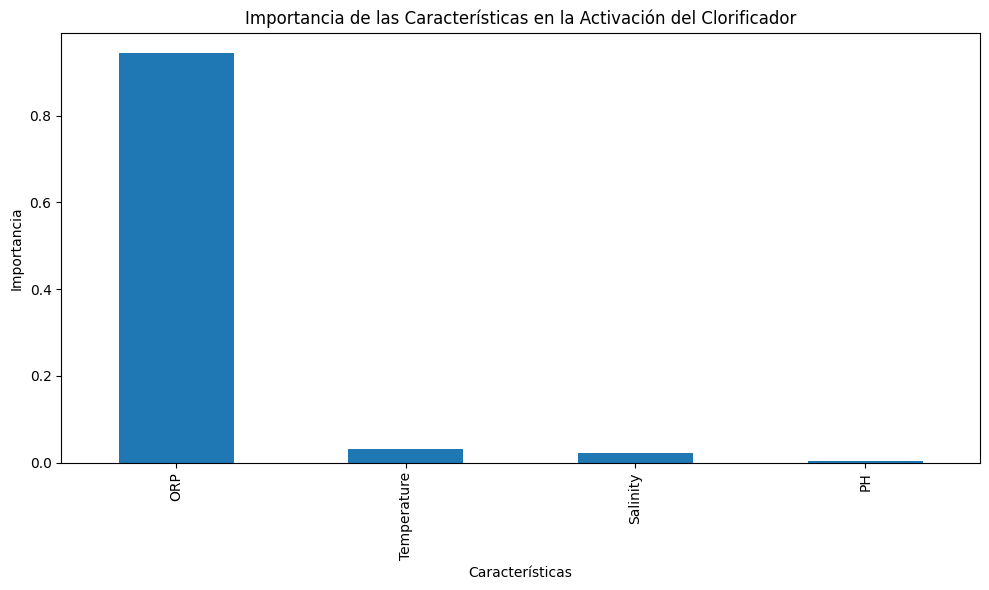

In [13]:
# Visualizamos la importancia de las características
imp_clf = clf.feature_importances_
feature_imp_clf = pd.Series(imp_clf, index=X_clf.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_imp_clf.plot(kind='bar')
plt.title('Importancia de las Características en la Activación del Clorificador')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.tight_layout()
plt.show()

# 2.Modelo de Predicción de pH

Preparamos los datos, escalamos y entrenamos un modelo. Desarrollaremos los dos modelos interconectados.

En sistemas dinámicos como una piscina, los valores actuales de pH dependen tanto de las condiciones presentes como de las pasadas. Para capturar esta relación temporal, se pueden utilizar valores anteriores (rezagados) del pH y el ORP. Esto nos permite ver cómo estos valores históricos influyen en el pH actual. Por ejemplo:

- El pH actual puede estar influenciado por sus valores anteriores debido a la inercia química del agua.
- Los cambios en ORP (potencial de oxidación-reducción) pueden tener un efecto retardado sobre el pH.
- Para capturar esta influencia, crearemos una nueva columna con los valores de pH desplazados una posición hacia abajo, representando el valor de pH en el tiempo anterior.

In [50]:
# Variables de rezago
for i in range(1, 4):  
    df_01[f'PH_lag_{i}'] = df_01['PH'].shift(i)
    df_01[f'ORP_lag_{i}'] = df_01['ORP'].shift(i)

df_01.dropna(inplace=True)

# Preparamps features y target
X_reg = df_01[['ORP', 'Salinity', 'Temperature', 'PH_lag_1', 'PH_lag_2', 'PH_lag_3', 
               'ORP_lag_1', 'ORP_lag_2', 'ORP_lag_3', 'Predict_Cl']]
y_reg = df_01['PH']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Normalizamos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reg)
X_test_scaled = scaler.transform(X_test_reg)

caracteristicas = X_reg.columns.tolist()

print("Forma de los datos de entrenamiento:", X_train_scaled.shape)
print("Forma de los datos de prueba:", X_test_scaled.shape)
print("Características utilizadas:", X_reg.columns.tolist())


Forma de los datos de entrenamiento: (3466, 10)
Forma de los datos de prueba: (867, 10)
Características utilizadas: ['ORP', 'Salinity', 'Temperature', 'PH_lag_1', 'PH_lag_2', 'PH_lag_3', 'ORP_lag_1', 'ORP_lag_2', 'ORP_lag_3', 'Predict_Cl']


## Comparación de Modelos

Compararemos varios modelos de regresión para predecir el pH para ver cual se ajusta mejor al funcionamiento de nuestr sistema.

1. Regresión Lineal: Modelo simple que asume una relación lineal entre las variables. Este aunque sencillo podria ajustarse a nuestras necesidades dado que sabemos que existe una relacion creciente entre los parametros.
2. Random Forest: Conjunto de árboles de decisión que podria ayudarnos a capturar relaciones no lineales existentes entre los parametros.
3. Gradient Boosting:Construye modelos de forma iterativa.
4. Red Neuronal: Puede aprender patrones complejos y no lineales en los datos que le aportamos.


C:\Users\hp\OneDrive\Escritorio\MASTER PYTHON 1\Master Python\11_Hacking\TFM\env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Regresión Lineal - MSE: 0.0111, R2: 0.4401
Random Forest - MSE: 0.0058, R2: 0.7060
Gradient Boosting - MSE: 0.0073, R2: 0.6325
Error en Red Neuronal: object __array__ method not producing an array


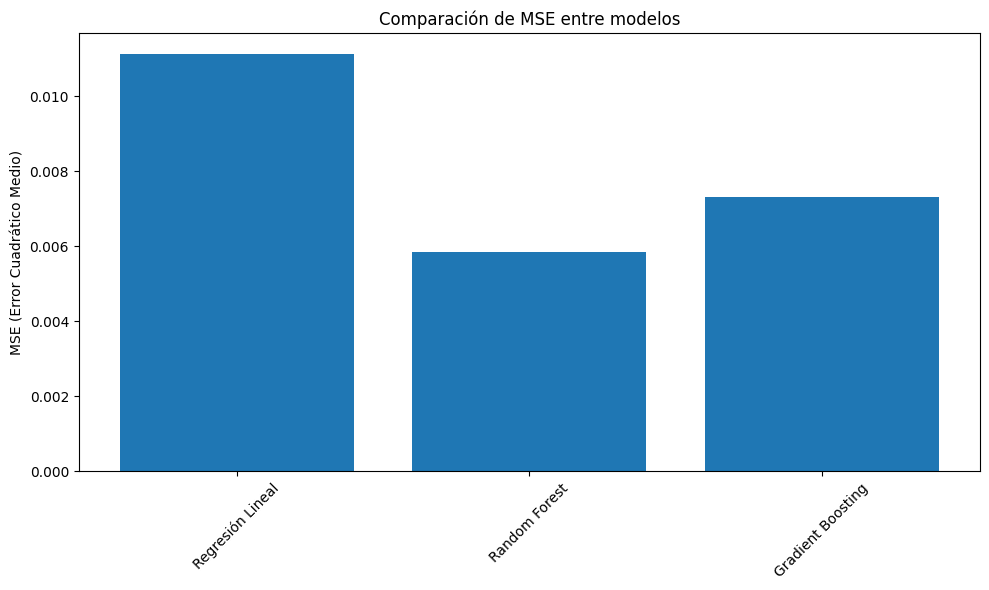

In [15]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

models = {
    'Regresión Lineal': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Red Neuronal': Sequential([
        Dense(64, activation='relu', input_shape=[X_train_scaled.shape[1]]),
        Dense(32, activation='relu'),
        Dense(1)
    ])
}

results = {}

for name, model in models.items():
    try:
        if name == 'Red Neuronal':
            model.compile(optimizer='adam', loss='mse')
            model.fit(X_train_scaled, y_train_reg, epochs=100, verbose=0)
            y_pred = model.predict(X_test_scaled)
            mse = mean_squared_error(y_test_reg, y_pred)
            r2 = r2_score(y_test_reg, y_pred)
        else:
            mse, r2 = evaluate_model(model, X_train_scaled, X_test_scaled, y_train_reg, y_test_reg)
        
        results[name] = {'MSE': mse, 'R2': r2}
        print(f"{name} - MSE: {mse:.4f}, R2: {r2:.4f}")
    except Exception as e:
        print(f"Error en {name}: {e}")

plt.figure(figsize=(10, 6))
plt.bar(results.keys(), [r['MSE'] for r in results.values()])
plt.title('Comparación de MSE entre modelos')
plt.ylabel('MSE (Error Cuadrático Medio)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*Conclusiones* 
A partir de la comparación del Error Cuadrático Medio  podemos concluir que el Random Forest es el modelo con mejor rendimiento, seguido de cerca por Gradient Boosting, lo que sugiere que las relaciones entre las variables de entrada y el pH no son lineales lo cual se confirma dado que La Regresión Lineal tiene el MSE más alto. La Red Neuronal, aunque muestra un rendimiento intermedio, no supera a los métodos basados en árboles, quiza mejoraria con mas datos de entrada. 

Optimizaremos el Random Forest y se hara un ajuste de los hiperparametros para los dos mejores modelos.

EL CODIGO DA UN ERROR QUE NO DABA ANTES ASI FUERON LOS RESULTADOS PREVIOS DONDE SE VE QUE LA RED NEURONAL SE DESCARTA COMO LA SEGUNDA PEOR OPCION:

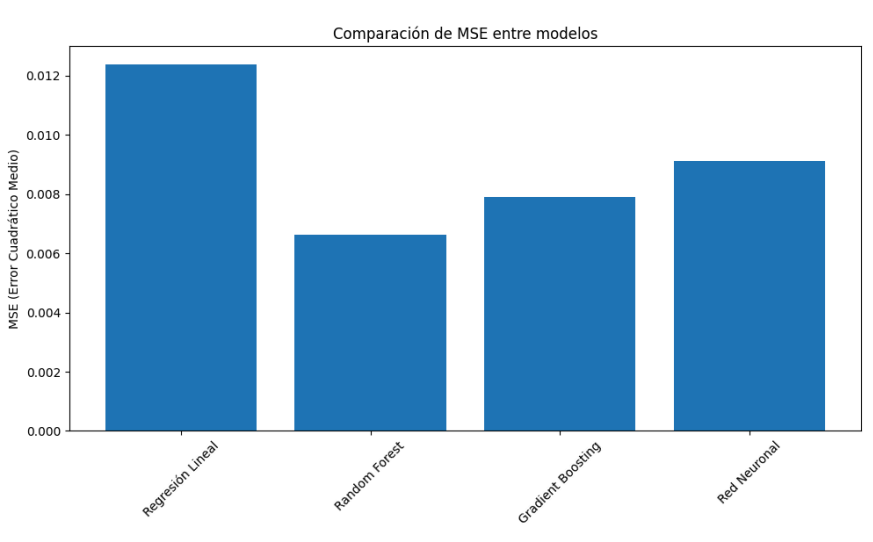
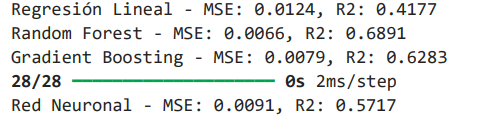

## Ajuste de hiperparametros

Una vez elegido el modelo buscamos los hiperparametros que mejor entrenen nuestro modelo, usamos randomsearch

In [16]:
# Clase Progreso para la barra de progreso poruqe s se nos quedaba pillado asi trackeamos
class Progreso:
    def __init__(self, total):
        self.barra_progreso = tqdm(total=total, desc="Optimizando parámetros")

    def __call__(self, estudio, prueba):
        self.barra_progreso.update(1)

    def cerrar(self):
        self.barra_progreso.close()

# Parámetros para Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [10, 20, 30],  
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['sqrt', 'log2'], 
    'bootstrap': [True, False]
}

num_iteraciones = 20
rastreador = Progreso(num_iteraciones)

# RandomizedSearchCV para Random Forest
try:
    rf_random_search = RandomizedSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_distributions=rf_param_grid,
        n_iter=num_iteraciones,
        cv=3,
        verbose=3,
        random_state=42,
        n_jobs=-1,
        scoring='neg_mean_squared_error'
    )

    rf_random_search.fit(X_train_scaled, y_train_reg)
    rastreador(None, None)

    print("\nMejores parámetros encontrados para Random Forest:\n")
    print(rf_random_search.best_params_)

    modelo_optimo_rf = rf_random_search.best_estimator_
    y_pred_rf = modelo_optimo_rf.predict(X_test_scaled)
    MSE_rf = mean_squared_error(y_test_reg, y_pred_rf)
    r2_rf = r2_score(y_test_reg, y_pred_rf)
    print(f"Random Forest optimizado - MSE: {MSE_rf:.4f}, R2: {r2_rf:.4f}")

except Exception as e:
    print(f"\nSe produjo un error durante la optimización de Random Forest: {str(e)}")

finally:
    rastreador.cerrar()


Optimizando parámetros:   0%|                    | 0/20 [00:00<?, ?it/s]

Fitting 3 folds for each of 20 candidates, totalling 60 fits


Optimizando parámetros:   5%|▌           | 1/20 [00:20<06:36, 20.85s/it]


Mejores parámetros encontrados para Random Forest:

{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}
Random Forest optimizado - MSE: 0.0057, R2: 0.7130


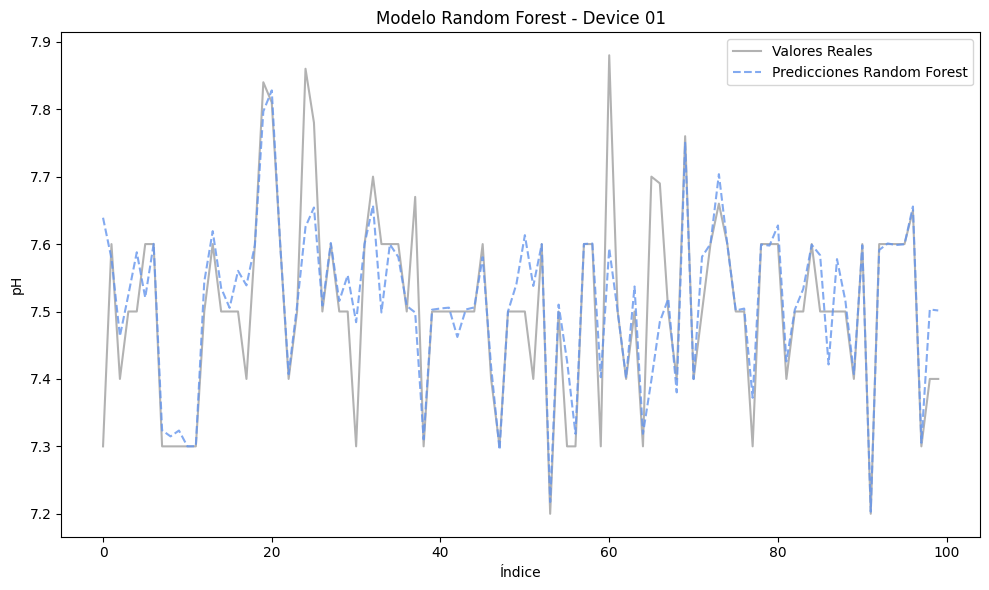

In [45]:
limite_puntos = 100

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(y_test_reg_reset[:limite_puntos], label='Valores Reales', color='grey', alpha=0.6)
ax.plot(y_pred_rf_reset[:limite_puntos], label='Predicciones Random Forest', linestyle='--', color='#6495ed', alpha=0.8)

ax.set_title(f'Modelo Random Forest - Device 01')
ax.set_xlabel('Índice')
ax.set_ylabel('pH')
ax.legend()


plt.tight_layout()
plt.show()

Vemos que el modelo funciona y se ajusta bastante bien a los datos. En futuras ocasiones podriamos comprobar si esto se debe a un buen modelo o si es la causa de un sobre entrenamiento, cuando vayamos colectadon mas data de esre device se proponda una extension del trabajo para probar el modelo y ver si funciona en datos nuevos.

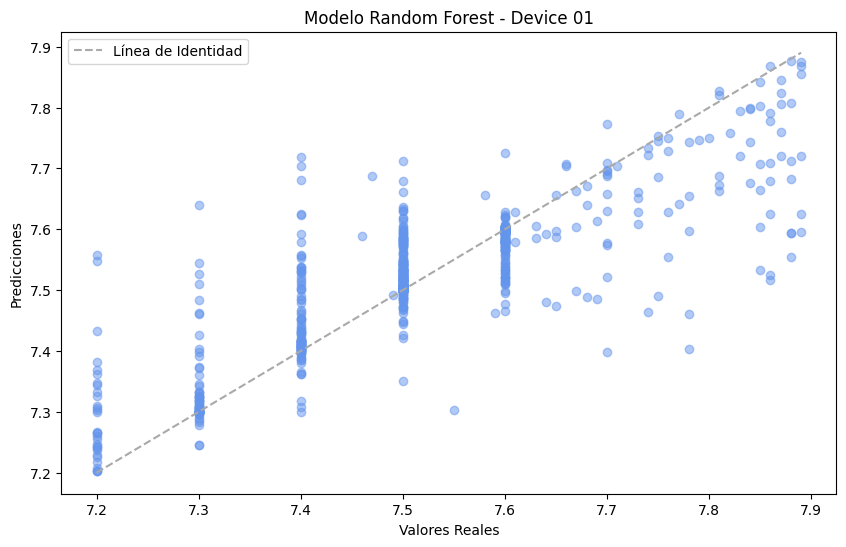

In [48]:
# Gráfica de dispersión: Predicciones vs Valores Reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg_reset, y_pred_rf_reset, alpha=0.5, color='#6495ed')
plt.plot([min(y_test_reg_reset), max(y_test_reg_reset)], [min(y_test_reg_reset), max(y_test_reg_reset)], color='#a9a9a9', linestyle='--', label='Línea de Identidad')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Modelo Random Forest - Device 01')
plt.legend()
plt.show()

La gráfica de dispersión revela que aunque las predicciones del modelo Random Forest siguen la tendencia general de los valores reales, existe una cierta dispersión alrededor de la línea de identidad, especialmente en los extremos de los valores de pH. Esto sugiere que el modelo predice razonablemente bien en el rango medio del pH, pero su precisión disminuye en los valores más altos y más bajos. 

### Importancia de las caracteristicas

- Medir la importancia de los otros inputs de entrada como valores previos y su tendencia, o otras columnas como Salinida, ORP...

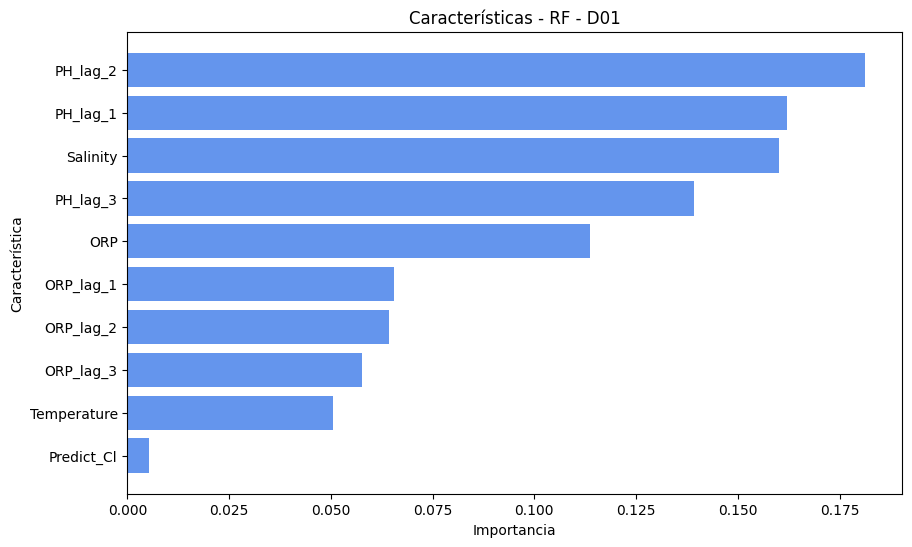

In [49]:
importancia_caracteristicas = modelo_optimo_rf.feature_importances_

importancia_df = pd.DataFrame({
    'Característica': caracteristicas, 
    'Importancia': importancia_caracteristicas
})

importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importancia_df['Característica'], importancia_df['Importancia'], color='#6495ed')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Características - RF - D01')
plt.gca().invert_yaxis()
plt.show()

Conclusiones de la importancia de las caracteristicas en el mejor modelo:

- pH Previo: El hecho de que las variables de rezago del pH sean tan dominantes sugiere que el comportamiento del pH es bastante autocorrelacionado. Es decir, el valor futuro del pH está altamente influenciado por sus valores pasados.

- Factores Ambientales: La salinidad y la temperatura son también factores importantes, aunque menos que el pH previo. Esto podría indicar que el pH está influenciado por el equilibrio químico y las condiciones del agua.

- ORP y Predict_Cl: Aunque estas características tienen un impacto, su menor importancia sugiere que, al menos en este modelo y conjunto de datos, su influencia en la predicción del pH es muy limitada, aunque su quimica diga lo contrario 

# Guardar el modelo

Guardamos el modelo para usarlo en alguno de nuestros otros devices y ver si responde bien , aunque cada piscina tiene condiciones diferentes , su modelo de funcionamiento es similar asi que queremos ver su precision. 

In [40]:
import joblib

In [41]:
joblib.dump(modelo_optimo_rf, 'modelo_random_forest_D1.pkl')

print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [43]:
X_train = df_01[['ORP', 'Salinity', 'Temperature', 'PH_lag_1', 'PH_lag_2', 'PH_lag_3', 
              'ORP_lag_1', 'ORP_lag_2', 'ORP_lag_3', 'Predict_Cl']]
y_train = df_01['PH']

# Ahora puedes obtener las características
caracteristicas_originales = X_train.columns.tolist()
print("Características utilizadas en el entrenamiento:", caracteristicas_originales)

Características utilizadas en el entrenamiento: ['ORP', 'Salinity', 'Temperature', 'PH_lag_1', 'PH_lag_2', 'PH_lag_3', 'ORP_lag_1', 'ORP_lag_2', 'ORP_lag_3', 'Predict_Cl']
